# Temp

Temporary file for testing new functions.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pickle
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [12, 4]

import quandl

from utils import *

In [3]:
from trading_strategies import *
test_RS_Trading_Strategy()

In [ ]:
from temp import *
price = pd.read_csv(filepath_or_buffer='test/Seykota GC----C.csv', header=None,
           names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Interest'], 
           index_col=0)

price.index = [datetime.strptime(str(i), '%Y%m%d') for i in price.index.values]

rs_tr = RS_Trading_Strategy(price, equity=1e6, position_step=1e2,
                            days_fast=20, days_slow=140,
                            name='Comex Gold')
rs_tr.excecute(warmup=20)

# test states
stts = rs_tr.get_state()
metrics = pd.merge(price[['Open', 'High', 'Low', 'Close']], stts, left_index=True, right_index=True)
metrics_log = pd.read_excel(io='test/Metrics_Log_1-1.xlsx', index_col=0)
assert np.all(np.equal(metrics_log.values, metrics.values))

# test trades
trds = rs_tr.get_trades()
trade_log = pd.read_excel(io='test/Trade_Log.xlsx').set_index('Date').sort_index()[['Price', 'Amount']]
assert max(abs(trds.Price.values - trade_log.Price.values)) < 1e-3
assert trds.Amount.equals(trade_log.Amount.astype('float64'))

# test equity
eqty = rs_tr.get_equity()
equity_log = pd.read_excel(io='test/Equity_Log.xlsx', index_col=0)
assert max(abs(eqty.Equity.values - equity_log.Equity.values)) < 1e-3
assert np.max(np.abs(equity_log.Clo_Bal - rs_tr.get_equity().Closing_Balance)) < 1e-3
assert np.max(np.abs(equity_log.Open_Profit - rs_tr.get_equity().Open_Profit)) < 1e-3

# test performance indicators
assert np.round(rs_tr.performance['ICAGR'], 4) == 0.0309
assert np.round(rs_tr.performance['Max_Drawdown'], 4) == 0.4077
assert np.round(rs_tr.performance['Bliss'], 4) == 0.0758

In [ ]:
from trading_strategies import *
test_RS_Trading_Strategy()
from temp import *

In [ ]:
es1 = ES1_Trading_Strategy(price, equity=1e6, position_step=1e2,
                           a=1e-2,
                           name='Comex Gold')

In [ ]:
es1.excecute()

In [ ]:
es1.performance

In [ ]:
es1.plot_state()

In [ ]:
es1.plot_equity()

In [ ]:
np.isnan(np.nan) * 1

# Pytorch 

In [4]:
import torch

In [5]:
# Simple example: y = (x1 - 2)^2 + (x2 - 5)^2
x = np.random.randn(2, 1)
x

array([[0.70211947],
       [0.69891209]])

In [6]:
x = torch.from_numpy(x)
x

tensor([[ 0.7021],
        [ 0.6989]], dtype=torch.float64)

In [7]:
x.requires_grad = True

In [19]:
y = (x[0] - 2)**2 + (x[1] - 5)**2

In [20]:
y.backward()

In [21]:
x.grad

tensor([[-2.0766],
        [-6.8817]], dtype=torch.float64)

In [22]:
print(2*(-0.77451728 - 2))
print(2 * (-0.64667186 - 3))

-5.54903456
-7.29334372


In [23]:
lr = 0.1
x.data.sub_(lr * x.grad)  # With '_', modifies in place.

tensor([[ 1.1694],
        [ 2.2473]], dtype=torch.float64)

In [24]:
x.grad

tensor([[-2.0766],
        [-6.8817]], dtype=torch.float64)

In [25]:
x.grad.zero_()

tensor([[ 0.],
        [ 0.]], dtype=torch.float64)

In [26]:
x.grad

tensor([[ 0.],
        [ 0.]], dtype=torch.float64)

## Gradient Descent 

In [27]:
# Gradient descent
lr = 0.1
steps = 30

def loss(x1, x2):
    return (x1 - 2)**2 + (x2 - 5)**2

x = torch.tensor(np.array([5., -4.]), requires_grad=True)
results = {'x1': [x.detach().numpy()[0]], 'x2': [x.detach().numpy()[1]],
           'loss': [loss(x.detach().numpy()[0], x.detach().numpy()[1])]}

for i in range(steps):
    y = loss(x[0], x[1])
    y.backward()
    x.data.sub_(lr * x.grad)  # With '_', modifies in place.
    x.grad.zero_()
    results['x1'].append(x.detach().numpy()[0])
    results['x2'].append(x.detach().numpy()[1])
    results['loss'].append(y.detach().numpy())


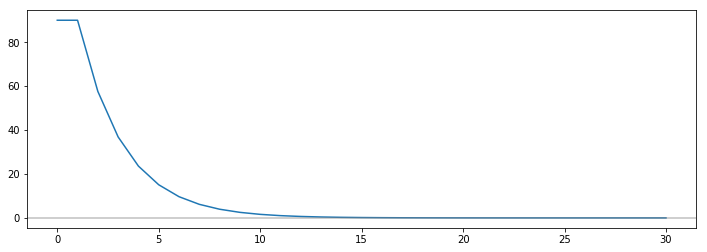

In [28]:
res_df = DataFrame.from_dict(results)
plt.plot(res_df.loss)
plt.axhline(y=0, c='grey', alpha=0.5)
plt.show()

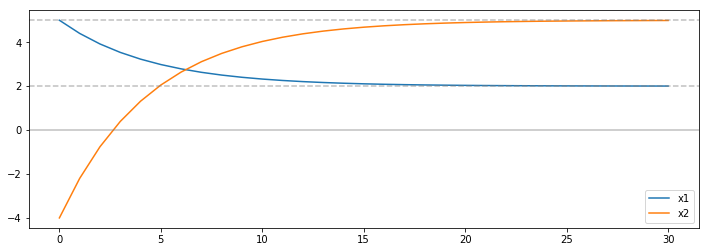

In [29]:
res_df.plot()
plt.axhline(y=2, c='grey', ls='dashed', alpha=0.5)
plt.axhline(y=5, c='grey', ls='dashed', alpha=0.5)
plt.axhline(y=0, c='grey', alpha=0.5)
plt.show()

In [30]:
res_df

,x1,x2,loss
0,5.000000,-4.000000,90
1,4.400000,-2.200000,90.0
2,3.920000,-0.760000,57.60000000000001
3,3.536000,0.392000,36.864
4,3.228800,1.313600,23.592960000000005
...,...,...,...
26,2.009067,4.972799,0.0012845229234353854
27,2.007254,4.978239,0.0008220946709986565
28,2.005803,4.982591,0.0005261405894391414
29,2.004642,4.986073,0.0003367299772410381


## Gradient Descent with Constraints

$$ y = (x_1 - 2)^2 + (x_2 - 5)^2, \quad x_1 >= 3 $$

In [31]:
# Gradient descent
lr = 0.01
steps = 1000

def loss(x1, x2):
    return (torch.clamp(x1, 3, 4) - 2)**2 + (x2 - 5)**2

x = torch.tensor(np.array([3.5, -25.]), requires_grad=True)
results = {'x1': [x.detach().numpy()[0]], 'x2': [x.detach().numpy()[1]],
           'loss': [loss(x[0], x[1]).detach().numpy()]}

for i in range(steps):
    y = loss(x[0], x[1])
    y.backward()
    x.data.sub_(lr * x.grad)  # With '_', modifies in place.
    x.grad.zero_()
    results['x1'].append(x.detach().numpy()[0])
    results['x2'].append(x.detach().numpy()[1])
    results['loss'].append(y.detach().numpy())


In [32]:
res_df = DataFrame.from_dict(results)
res_df

,x1,x2,loss
0,3.500000,-25.000000,902.25
1,3.470000,-24.400000,902.25
2,3.440600,-23.812000,866.5208999999999
3,3.411788,-23.235760,832.2066723599999
4,3.383552,-22.671045,799.2512881345439
...,...,...,...
996,2.981384,5.000000,1.000000000000003
997,2.981384,5.000000,1.0000000000000029
998,2.981384,5.000000,1.0000000000000029
999,2.981384,5.000000,1.0000000000000027


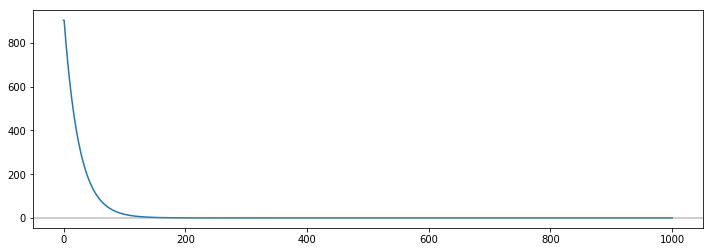

In [33]:
res_df = DataFrame.from_dict(results)
plt.plot(res_df.loss)
plt.axhline(y=0, c='grey', alpha=0.5)
plt.show()

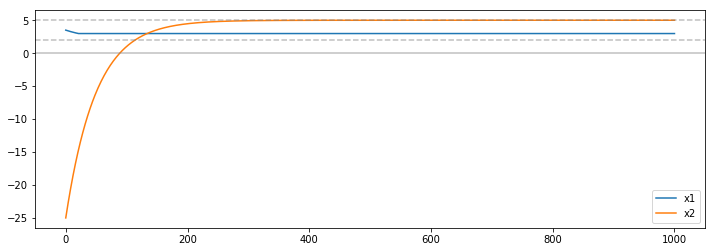

In [34]:
res_df.plot()
plt.axhline(y=2, c='grey', ls='dashed', alpha=0.5)
plt.axhline(y=5, c='grey', ls='dashed', alpha=0.5)
plt.axhline(y=0, c='grey', alpha=0.5)
plt.show()

## Exponential Smoothing Optimization

In [212]:
N = 100
n = 50
a = 0.1
x = np.cumsum(np.random.randn(N))

In [213]:
def moving_average(x, n):
    mav = x.copy()
    for i in range(1, len(mav)):
        mav[i] = np.mean(x[:i][-n:])
    return(mav)


def exponential_smoothing(x, a):
    esm = x.copy()
    for i in range(1, len(esm)):
        esm[i] = a * x[i] + (1 - a) * esm[i - 1]
    return(esm)


def exponential_smoothing_t(x, a):
    esm = [torch.tensor(x[0])]
    for i in range(1, len(x)):
        esm.append(a * x[i] + (1 - a) * esm[-1])
    return(esm)

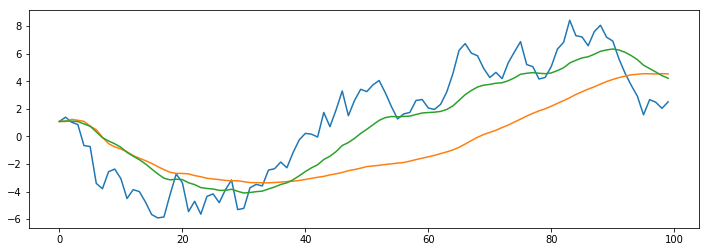

In [214]:
plt.plot(x)
plt.plot(moving_average(x, n))
plt.plot(exponential_smoothing(x, a))
plt.show()

In [226]:
# Gradient descent
lr = 0.001
steps = 100

mav_t = torch.from_numpy(moving_average(x, n))

def loss(x, aa):
    l = torch.tensor(0., dtype=torch.float64)
    esm_t = exponential_smoothing_t(x_t, aa)
    for i in range(len(esm_t)):
        l.add_((mav_t[i] - esm_t[i])**2)
    return l

x_t = torch.tensor(x)
a_t = torch.tensor(a, requires_grad=True, dtype=torch.float64)

results = {'a': [a_t.detach().numpy()], 
           'loss': [loss(x_t, a_t).detach().numpy()]}

for i in range(steps):
    y = loss(x_t, a_t)
    y.backward()
    a_t.data.sub_(lr * a_t.grad)  # With '_', modifies in place.
    a_t.grad.zero_()
    results['a'].append(a_t.detach().numpy())
    results['loss'].append(y.detach().numpy())


In [227]:
a_t

tensor(nan., dtype=torch.float64)

In [228]:
res_df = DataFrame.from_dict(results)
res_df

,a,loss
0,nan,424.1570097185271
1,nan,424.1570097185271
2,nan,1.6904684237203734e+154
3,nan,inf
4,nan,nan
...,...,...
96,nan,nan
97,nan,nan
98,nan,nan
99,nan,nan


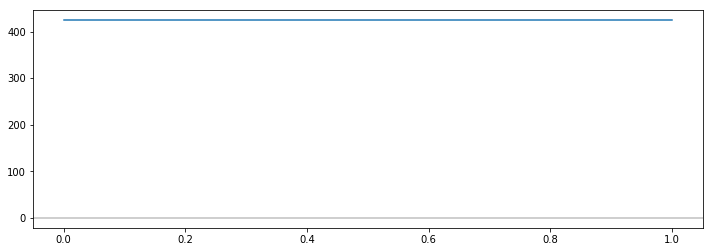

In [217]:
res_df = DataFrame.from_dict(results)
plt.plot(res_df.loss)
plt.axhline(y=0, c='grey', alpha=0.5)
plt.show()

In [218]:
res_df.plot()
plt.axhline(y=2, c='grey', ls='dashed', alpha=0.5)
plt.axhline(y=5, c='grey', ls='dashed', alpha=0.5)
plt.axhline(y=0, c='grey', alpha=0.5)
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

In [202]:
loss.backward()

In [206]:
a_t.grad

tensor(95621.9554, dtype=torch.float64)

## Exponential Smoothing Trading system 

In [47]:
price = pd.read_csv(filepath_or_buffer='test/Seykota GC----C.csv', header=None,
           names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Interest'], 
           index_col=0)

price.index = [datetime.strptime(str(i), '%Y%m%d') for i in price.index.values]
y = np.random.randn(len(price))

In [ ]:
class Trading_Strategy:
    """
    Class that performs a trading strategy on a single asset.
    """
    
    def __init__(self, prices, equity=100, heat=0.05, position_step=100, name='', **kwargs):
        """
        Defines the initial state and hyper parameters of the trading strategy.
        
        Parameters
        ----------
        prices: DataFrame with columns Date, Open, High, Low, Close
        equity: Initial equity to invest in the asset.
        heat: Proportion of the equity that one is willing to risk.
        position_step: Minimum steps in position' sizes
        name: Name of the asset for plotting purposes.
        """
        self.dates = prices.index
        self.first_trading_day = None
        self.last_trading_day = None
        self.prices_df = prices
        self.prices = {s: prices[s].values for s in list(prices.keys())}
        self.heat = heat
        self.position_step = position_step
        self.name = name
        self.today_prices = None
        
        self.equity = {'Available_Balance': torch.ones(len(self.dates), dtype=torch.float64) * equity,
                       'Closing_Balance': torch.ones(len(self.dates), dtype=torch.float64) * equity,
                       'Position': torch.zeros(len(self.dates), dtype=torch.float64),
                       'Open_Profit': torch.zeros(len(self.dates), dtype=torch.float64),
                       'Position_Value': torch.zeros(len(self.dates), dtype=torch.float64),
                       'Equity': torch.ones(len(self.dates), dtype=torch.float64) * equity}
        
        self.orders = {'buy_stop': torch.zeros(len(self.dates), dtype=torch.float64) * np.nan,
                       'sell_stop': torch.zeros(len(self.dates), dtype=torch.float64) * np.nan,
                       'protective_buy': torch.zeros(len(self.dates), dtype=torch.float64) * np.nan,
                       'protective_sell': torch.zeros(len(self.dates), dtype=torch.float64) * np.nan,
                       'risk_per_lot': torch.zeros(len(self.dates), dtype=torch.float64) * np.nan,
                       'amount': torch.zeros(len(self.dates), dtype=torch.float64) * np.nan}
        
        self.trades = []
        self.max_drawdown = 0
        self.performance = {}
        
        self.init_state(**kwargs)
    
    
    def init_state(self):
        pass
    
    
    def update_state(self, today_i):
        """
        Updates the state as of market close from today_i - 1, for determining orders before market openas today_i.
        """
        pass
    
    
    def orders_before_trading_starts(self, today_i):
        """
        Computes the orders for the day (today).
        
        Parameters
        ----------
        prices : a prices data frame with a Date index and columns: Open, High, Low, Close, Volume.
            Prices until today only for accessing current date.
        prev_day_position : position in the asset at the end of yesterday.
        """
        self.entry_order_prices(today_i)
        self.protective_order_prices(today_i)
        self.order_amounts(today_i)
    
    
    def entry_order_prices(self, today_i):
        """
        Computes the entry orders for the day (today) according to a Support and Resistance system.
        """
        pass
    
    
    def protective_order_prices(self, today_i):
        """
        Computes the protective orders for the day (today) according to a Support and Resistance system.
        """
        pass
    
    
    def order_amounts(self, today_i):
        """
        Sets the order amounts for the day
        """
        equity_to_risk = self.equity['Available_Balance'][today_i - 1] * self.heat

        if self.orders['buy_stop'][today_i] > 0 and self.orders['protective_sell'][today_i] > 0:
            self.orders['risk_per_lot'][today_i] = self.orders['buy_stop'][today_i] - \
                self.orders['protective_sell'][today_i] + 1e-12
            self.orders['amount'][today_i] = self.position_step * \
                    torch.round((1e-8 + equity_to_risk / self.orders['risk_per_lot'][today_i]) / self.position_step)
        
        elif self.orders['sell_stop'][today_i] > 0 and self.orders['protective_buy'][today_i] > 0:
            self.orders['risk_per_lot'][today_i] = self.orders['protective_buy'][today_i] - \
                self.orders['sell_stop'][today_i] + 1e-12
            self.orders['amount'][today_i] = - self.position_step * \
                torch.round((1e-8 + equity_to_risk / self.orders['risk_per_lot'][today_i]) / self.position_step)
        else:
            pass
    
    
    def excecute_orders(self, today_i, skid=0.5):
        """
        Excecutes orders during the day.
        """
        
        position = self.equity['Position'][today_i - 1]  # previous day's position
        balance = self.equity['Available_Balance'][today_i - 1]  # previous day's balance
        o = {k: self.orders[k][today_i] for k in self.orders.keys()}  # orders for the day
        tp = self.today_prices

        if position == 0:  # Enter the market.

            if not np.isnan(o['buy_stop'].detach()) and not np.isnan(o['protective_sell'].detach()) and \
                o['buy_stop'] > o['protective_sell'] and tp['High'] > o['buy_stop']:
                
                buy_price = tp['High'] - skid * (tp['High'] - max(tp['Open'], tp['Low'], o['buy_stop']))
                trade = {'Date': self.dates[today_i],
                         'Price': buy_price,
                         'Amount': min(o['amount'], balance)}
                position += o['amount']
                balance -= o['amount'] * buy_price
                self.trades.append(trade)


            elif not np.isnan(o['sell_stop'].detach()) and not np.isnan(o['protective_buy'].detach()) and \
                o['sell_stop'] < o['protective_buy'] and tp['Low'] < o['sell_stop']:
                
                sell_price = tp['Low'] + skid * (min(tp['Open'], tp['High'], o['sell_stop']) - tp['Low'])
                trade = {'Date': self.dates[today_i],
                         'Price': sell_price,
                         'Amount': max(o['amount'], -balance)}  # o['amount'] < 0
                position += o['amount']
                balance -= o['amount'] * sell_price
                self.trades.append(trade)

        if position != 0:  # Close positions.

            if not np.isnan(o['protective_buy'].detach()) and tp['High'] > o['protective_buy']:
                
                buy_price = tp['High'] - skid * (tp['High'] - max(tp['Open'], tp['Low'], o['protective_buy']))
                amount = max(-position, 0)
                trade = {'Date': self.dates[today_i],
                         'Price': buy_price,
                         'Amount': amount}
                position += amount
                balance -= amount * buy_price
                self.trades.append(trade)

            if not np.isnan(o['protective_sell'].detach()) and tp['Low'] < o['protective_sell']:
                
                sell_price = tp['Low'] + skid * (min(tp['Open'], tp['High'], o['protective_sell']) - tp['Low'])
                amount = min(-position, 0)
                trade = {'Date': self.dates[today_i],
                         'Price': sell_price,
                         'Amount': amount}
                position += amount
                balance -= amount * sell_price
                self.trades.append(trade)

        if self.dates[today_i] == self.dates[-1] and position != 0:  # Last day
            
            if position > 0:
                
                sell_price = tp['Low'] + skid * (min(tp['Open'], tp['Close'], tp['High']) - tp['Low'])
                amount = min(-position, 0)
                trade = {'Date': self.dates[today_i],
                         'Price': sell_price,
                         'Amount': amount}
                position += amount
                balance -= amount * sell_price
                self.trades.append(trade)
                
            else:  # position < 0
                
                buy_price = tp['High'] - skid * (tp['High'] - max(tp['Open'], tp['Close'], tp['Low']))
                amount = max(-position, 0)
                trade = {'Date': self.dates[today_i],
                         'Price': buy_price,
                         'Amount': amount}
                position += amount
                balance -= amount * buy_price
                self.trades.append(trade)

        if position != 0:
            open_profit = position * (tp['Close'] - self.trades[-1]['Price'])
        else:
            open_profit = 0

        if self.equity['Position'][today_i - 1] != 0 and position == 0:
            closing_balance = balance
        else:
            closing_balance = self.equity['Closing_Balance'][today_i - 1]


        
        self.equity['Available_Balance'][today_i] = balance
        self.equity['Closing_Balance'][today_i] = closing_balance
        self.equity['Position'][today_i] = position
        self.equity['Open_Profit'][today_i] = open_profit
        self.equity['Position_Value'][today_i] = position * tp['Close']
        self.equity['Equity'][today_i] = balance + position * tp['Close']
    
    
    
    
    def excecute(self, warmup=25, end=None, skid=0.5):
        """
        Excecutes the trading strategy and computes its performance measures.
        
        Parameters
        ----------
        warmup: warmup period in days or a proportion from 0 to 1.
        end: either a datetime or a proportion from 0 to 1 (all sample).
        """
        peak = self.equity['Equity'][0]
        low = peak
        drawdown = 0
        max_drawdown = 0
        
        if end is None:
            end = self.dates[-1]
        elif type(end) == float:
            end = self.dates[int(len(self.dates) * end)]
        
        
        if warmup < 1:
            warmup = int(len(self.dates) * warmup)
            
        self.first_trading_day = self.dates[warmup]
        self.last_trading_day = end
        
        for i in range(1, len(self.dates)):
            self.today_prices = {k: self.prices[k][i] for k in self.prices.keys()}
            self.update_state(i)
            if i >= warmup:
                self.orders_before_trading_starts(i)
                self.excecute_orders(i, skid)
                
                # Max drawdown
                if self.equity['Equity'][i] > peak:
                    peak = self.equity['Equity'][i]
                    low = peak
                if self.equity['Equity'][i] < low:
                    low = self.equity['Equity'][i]
                    drawdown = low / peak - 1
                max_drawdown = min(drawdown, max_drawdown)
                
            if self.dates[i] > end:
                self.equity['Available_Balance'][i] = self.equity['Available_Balance'][i - 1]
                self.equity['Closing_Balance'][i] = self.equity['Closing_Balance'][i - 1]
                self.equity['Position'][i] = self.equity['Position'][i - 1]
                self.equity['Open_Profit'][i] =  self.equity['Position'][i] * \
                    (self.prices['Close'][i] - self.trades[-1]['Price'])
                self.equity['Position_Value'][i] = self.equity['Position'][i] * self.prices['Close'][i]
                self.equity['Equity'][i] = self.equity['Equity'][i - 1]
        
        self.max_drawdown = max_drawdown
        self.compute_performance()
    
    
    def compute_performance(self):
        """
        Computes performance indicators for the trading strategy.
        """
        
        self.performance['Years'] = (self.last_trading_day - self.first_trading_day).days / 364.25
        self.performance['Ratio'] = self.equity['Equity'][-1] / self.equity['Equity'][0]
        # Instantaneously Compounding Annual Gain
        self.performance['ICAGR'] = torch.log(self.performance['Ratio']) / self.performance['Years']
        self.performance['Max_Drawdown'] = -self.max_drawdown
        # How Often the System Earns Back its Biggest Drawdown
        self.performance['Bliss'] = self.performance['ICAGR'] / self.performance['Max_Drawdown']
        
        eqty = self.equity['Equity'][np.where(self.dates > self.first_trading_day)]
        self.performance['Volatility'] = torch.std(torch.log(eqty[1:] / eqty[:-1])) * np.sqrt(364.25)
        
        # Lake Ratio (see http://www.seykota.com/tribe/risk/index.htm)
        lake_bottom = Series(eqty.detach()) / self.equity['Equity'][1].detach()
        lake_surface = lake_bottom.cummax()

        earth = np.trapz(lake_bottom.values)
        water = np.trapz(lake_surface - lake_bottom)
        self.performance['Lake_Ratio'] = water / earth
        
        earth0 = np.trapz(lake_bottom.values - 1)
        self.performance['Sea_Ratio'] = water / earth0
    
    
    
    def get_prices(self):
        return self.prices_df
    
    
    def get_state(self):
        if not any([i == 'state_df' for i in dir(self)]):
            self.state_df = DataFrame(self.state, index=self.dates).iloc[:-1]
        return self.state_df
    
    
    def get_orders(self):
        if not any([i == 'orders_df' for i in dir(self)]):
            self.orders_df = DataFrame(self.orders, index=self.dates)
        return self.orders_df
    
    
    def get_trades(self):
        if not any([i == 'trades_df' for i in dir(self)]):
            self.trades_df = dict_list_to_DataFrame(self.trades).set_index('Date')
        return self.trades_df
    
    
    def get_equity(self):
        if not any([i == 'equity_df' for i in dir(self)]):
            self.equity_df =DataFrame(self.equity, index=self.dates)
        return self.equity_df
    
    
    
    def plot_prices(self):
        fig, ax = pyplot.subplots()
        ax.plot(self.prices_df.Open)
        ax.plot(self.prices_df.High)
        ax.plot(self.prices_df.Low)
        ax.plot(self.prices_df.Close)
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.set_title(self.name)
        ax.legend()
    
    
    def plot_state(self):
        x = pandas.merge(self.prices_df[['Open', 'High', 'Low', 'Close']],
                         self.get_state(), left_index=True, right_index=True, how='outer')
        x.plot()
    
    
    def plot_equity(self):
        x = pandas.merge(self.get_equity(), self.get_state(), left_index=True, right_index=True, how = 'outer')
        tit = self.name + ', '
        tit += 'heat: ' + str(self.heat) + '.\n'
        tit += 'Initial Equity: ' + str(int(self.equity['Equity'][0]))
        tit += ', Ending Equity: ' + str(int(self.equity['Equity'][-1])) + ', '
        tit += 'Total Return: ' + str(int(10000 * self.equity['Equity'][-1] / self.equity['Equity'][1] - 1) / 100) + '%.\n'
#         tit += 'ICAGR: ' + str(int(10000 * self.performance['ICAGR']) / 100) + '%.\n'
#         tit += 'Volatility: ' + str(int(10000 * self.performance['Volatility']) / 100) + '%, '
        tit += 'Lake Ratio: ' + str(int(10000 * self.performance['Lake_Ratio']) / 100) + '%, '
        tit += 'Max. Drawdown: ' + str(int(10000* self.performance['Max_Drawdown']) / 100) + '%, '
#         tit += 'Bliss: ' + str(torch.round(364.25 * self.performance['Bliss'], 1)) + ' days.'
        pal = pyplot.get_cmap('Paired').colors
        fig, ax = pyplot.subplots()
        trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(x.index, 0, x.Equity.max(), where= x.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
        ax.fill_between(x.index, 0, x.Equity.max(), where= x.Trend < 0, facecolor=pal[4],
                        alpha=0.25, transform=trans, label='Trend down')
        ax.plot(x.index, x.Equity)
        ax.plot(x.index, x.Closing_Balance)
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.set_title(tit)
        ax.legend()
    
    
    def plot_lake_ratio(self):
        """
        Illustrates the computation of the lake ratio.
        See http://www.seykota.com/tribe/risk/index.htm
        """
        eqty = self.equity['Equity'][self.dates > self.first_trading_day]
        lake_bottom = Series(eqty) / self.equity['Equity'][1]
        lake_surface = lake_bottom.cummax()
        fig, ax = pyplot.subplots()
        ax.fill_between(lake_bottom.index, y1 = lake_bottom, y2 = lake_surface, alpha=0.5)
        ax.fill_between(lake_bottom.index, y1 = 0, y2 = lake_bottom, alpha=0.5)
        ax.axhline(1, color='grey', lw=2, alpha=0.75)
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.plot(lake_bottom)
        tit = 'Lake Ratio: ' + str(int(10000 * self.performance['Lake_Ratio']) / 100) + '%'
        tit += ', Sea Ratio (areas over 1): ' + str(int(10000 * self.performance['Sea_Ratio']) / 100) + '%.'
        ax.set_title(tit)

In [82]:
class ES1_Trading_Strategy_torch(Trading_Strategy):
    """
    Implements a simple exponential smoothing trading system.
    """
    def init_state(self, a=0.1):
        """
        Parameters
        ----------
        a: exponential smoothing constant between 0 and 1. S_t = a * P_t + (1 - a) * S_t-1
        """

        self.state = {'esa': torch.from_numpy(np.zeros(len(self.dates))),
                      'Trend': torch.from_numpy(np.zeros(len(self.dates)))}
        self.prices = {s: torch.from_numpy(self.prices[s]) for s in list(self.prices.keys())}
        self.a = torch.tensor(min(max(a, 0), 1), dtype=torch.float64, requires_grad=True)
        
    
    
    def update_state(self, today_i):
        """
        Updates the Resistance, Support, and Trend variables.
        """
        if today_i == 1:
            self.state['esa'][0].add_(self.prices['Close'][0])
            self.state['Trend'][0] = 0
        else:      
            self.state['esa'][today_i - 1].add_(self.a.clone() * self.prices['Close'][today_i - 1] + \
                (1 - self.a.clone()) * self.state['esa'][today_i - 2])
            self.state['Trend'][today_i - 1] = torch.sign(self.prices['Close'][today_i - 1] - self.state['esa'][today_i - 1])
    
    
    def entry_order_prices(self, today_i):
        """
        Computes the entry orders for the day (today).
        """
        prev_day_position = self.equity['Position'][today_i - 1]
        state = {k: self.state[k][today_i - 1] for k in self.state.keys()}
        
        if prev_day_position == 0:
            if state['Trend'] == 1:
                self.orders['buy_stop'][today_i] = self.prices['High'][today_i - 1]
            elif state['Trend'] == -1:
                self.orders['sell_stop'][today_i] = self.prices['Low'][today_i - 1]
            else:
                pass
        else:
            pass
    
    
    
    def protective_order_prices(self, today_i):
        """
        Computes the protective orders for the day (today) according to a Support and Resistance system.
        """
        state = {k: self.state[k][today_i - 1] for k in self.state.keys()}
        prev_day_position = self.equity['Position'][today_i - 1]
        
        if self.orders['buy_stop'][today_i] > 0 or prev_day_position > 0:
            self.orders['protective_sell'][today_i] = state['esa']
            
        elif self.orders['sell_stop'][today_i] > 0 or prev_day_position < 0:
            self.orders['protective_buy'][today_i] = state['esa']
            
        else:
            pass

In [83]:
es1 = ES1_Trading_Strategy_torch(price, equity=1e6, position_step=1e2,
                           a=0.3, name='Comex Gold')

In [84]:
print(es1.a)
print(es1.state['esa'])
print(es1.prices)
print(es1.orders)

tensor(0.3000, dtype=torch.float64)
tensor([ 0.,  0.,  0.,  ...,  0.,  0.,  0.], dtype=torch.float64)
{'Open': tensor([  762.3000,   752.9000,   742.4000,  ...,   470.2000,
          466.4000,   469.5000], dtype=torch.float64), 'High': tensor([  762.3000,   754.4000,   745.4000,  ...,   470.2000,
          470.5000,   470.9000], dtype=torch.float64), 'Low': tensor([  752.6000,   742.9000,   739.4000,  ...,   464.3000,
          462.3000,   461.2000], dtype=torch.float64), 'Close': tensor([  754.6000,   745.1000,   744.4000,  ...,   467.2000,
          469.5000,   466.2000], dtype=torch.float64), 'Volume': tensor([ 1.2150e+03,  1.7210e+03,  1.1080e+03,  ...,  5.5002e+04,
         6.1123e+04,  0.0000e+00]), 'Open_Interest': tensor([ 7.1100e+02,  1.3090e+03,  1.5510e+03,  ...,  2.8849e+05,
         2.9562e+05,  0.0000e+00])}
{'buy_stop': array([nan, nan, nan, ..., nan, nan, nan]), 'sell_stop': array([nan, nan, nan, ..., nan, nan, nan]), 'protective_buy': array([nan, nan, nan, ..., nan, na

In [85]:
for i in range(len(price)):
    es1.update_state(i)

In [86]:
loss = torch.sum((es1.state['esa'][:10] - torch.from_numpy(y[:10]))**2)

In [87]:
loss.backward()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation

In [39]:
es1.excecute()

/Users/juanpabloacosta/GitHub/trend-following/trading_strategies.py:297: RuntimeWarning: invalid value encountered in log
  self.performance['Volatility'] = numpy.std(numpy.log(eqty[1:] / eqty[:-1])) * numpy.sqrt(364.25)


In [ ]:
es1.performance['Ratio'].requires_grad

In [ ]:
# See https://discuss.pytorch.org/t/encounter-the-runtimeerror-one-of-the-variables-needed-for-gradient-computation-has-been-modified-by-an-inplace-operation/836
es1.performance['Ratio'].backward()